Imports

In [2]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import os
import shutil
from PIL import Image
from tqdm import tqdm

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# torchvision imports
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# sklearn imports
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# skimage imports
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


Prepare Data for Training and Testing

In [ ]:


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
def load_data(img_dir):
    x_data = []
    image_paths = [os.path.join(img_dir, w) for w in os.listdir(img_dir) if w.endswith(('.png', '.jpg', '.jpeg'))]
    for image_path in tqdm(image_paths):
        img = Image.open(image_path).convert('L')  # Load image in grayscale
        img = img.resize((128, 128))  # Ensure image is 128x128
        x_data.append(np.array(img))
    return np.array(x_data)

# Prepare Data
data = load_data("/home/thumbnails128x128")
data = data.astype('float32')/255

# Add channel dimension
data = data[..., np.newaxis]

# Convert to Tensors and permute to match the expected shape [batch_size, channels, height, width]
data_tensor = torch.tensor(data).float().permute(0, 3, 1, 2).to(device)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(data_tensor)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Shuffle the dataset
indices = torch.randperm(total_size).tolist()

# Split indices for each dataset
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create TensorDataset from shuffled data
train_dataset = TensorDataset(data_tensor[train_indices], data_tensor[train_indices])
val_dataset = TensorDataset(data_tensor[val_indices], data_tensor[val_indices])
test_dataset = TensorDataset(data_tensor[test_indices], data_tensor[test_indices])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the sizes of each dataset
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Define VAE Model

Reparametrization trick 

In [ ]:
# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

Encoder

In [6]:
class VaeEncoder(nn.Module):

    def __init__(self, x_dim=128*128, hidden_size=512, z_dim=200, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  

    def bottleneck(self, h):

        mu, logvar = self.fc1(h), self.fc2(h)
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):

        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar


Decoder

In [7]:
class VaeDecoder(nn.Module):

    def __init__(self, x_dim=128*128, hidden_size=512, z_dim=200):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [8]:
class Vae(nn.Module):
    def __init__(self, x_dim=128*128, z_dim=200, hidden_size=512, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1):
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):

        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z


Define Loss function with different regularization

In [9]:

def loss_function(recon_x, x, mu, logvar, model, loss_type='mse', lambda_l1=0.0, lambda_l2=0.0, use_l1=False, use_l2=False):
    """
    This function calculates the loss of the VAE with optional L1 and L2 regularization.
    
    Loss = reconstruction_loss + KL-divergence + regularization_loss
    """
    # Compute reconstruction loss
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError(f"Loss type '{loss_type}' not implemented")

    # Compute KL-divergence loss
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Compute regularization loss
    reg_terms = 0.0
    if use_l1 and lambda_l1 > 0:
        reg_terms += lambda_l1 * sum(p.abs().sum() for p in model.decoder.parameters())
    if use_l2 and lambda_l2 > 0:
        reg_terms += lambda_l2 * sum(p.pow(2.0).sum() for p in model.decoder.parameters())
    
    # Total loss
    total_loss = recon_error + kl + reg_terms
    
    return total_loss / x.size(0)  # Normalize by batch size


Define Hyperparameters for Training

In [10]:
# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 200  # how many epochs to run?
HIDDEN_SIZE = 512  # size of the hidden layers in the networks
X_DIM = 128 * 128  # size of the input dimension
Z_DIM = 200  # size of the latent dimension

Training Model with different Regularization methods

In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize variables for tracking loss
regularization_settings = [
    {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False},
    {'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True},
    {'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False},
    {'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True},
]

# Create lists to store training and validation losses for each regularization setting
all_train_losses = {}
all_val_losses = {}
best_val_loss = {}
best_model_state = {}

# Loop through each regularization setting
for reg_settings in regularization_settings:
    # Create model and optimizer
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)
    vae.train()
    
    # Generate label for this setting
    label = f"$\\lambda_{{L1}} = {reg_settings['lambda_l1']}, \\lambda_{{L2}} = {reg_settings['lambda_l2']}$"

    # Store losses for this setting
    train_losses = []
    val_losses = []
    
    # Initialize best validation loss as infinity
    best_val_loss[label] = float('inf')

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        batch_train_losses = []
        batch_val_losses = []

        # Training
        for batch in train_loader:
            x = batch[0].to(device).view(-1, X_DIM)  # just the images
            x_recon, mu, logvar, z = vae(x)
            # Calculate the loss with current regularization settings
            loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                 lambda_l1=reg_settings['lambda_l1'],
                                 lambda_l2=reg_settings['lambda_l2'],
                                 use_l1=reg_settings['use_l1'],
                                 use_l2=reg_settings['use_l2'])
            # Optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            batch_train_losses.append(loss.data.cpu().item())

        # Validation
        vae.eval()
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device).view(-1, X_DIM)
                x_recon, mu, logvar, z = vae(x)
                val_loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                         lambda_l1=reg_settings['lambda_l1'],
                                         lambda_l2=reg_settings['lambda_l2'],
                                         use_l1=reg_settings['use_l1'],
                                         use_l2=reg_settings['use_l2'])
                batch_val_losses.append(val_loss.data.cpu().item())

        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(np.mean(batch_val_losses))

        # Check if current validation loss is the best we've seen
        if val_losses[-1] < best_val_loss[label]:
            best_val_loss[label] = val_losses[-1]
            best_model_state[label] = vae.state_dict()

        print("Epoch: {} | Regularization: {} | Training Loss: {:.5f} | Validation Loss: {:.5f} | Time: {:.3f} sec".format(
            epoch, reg_settings, train_losses[-1], val_losses[-1], time.time() - epoch_start_time
        ))
    
    # Store losses for this regularization setting
    all_train_losses[label] = train_losses
    all_val_losses[label] = val_losses

    # Save the best model for this regularization setting
    best_model_path = f"./vae_best_{str(reg_settings)}.pth"
    torch.save(best_model_state[label], best_model_path)
    print(f"Best model for {label} saved at {best_model_path} with val loss {best_val_loss[label]:.4f}")

# Plot training losses with custom legend labels

for label, train_losses in all_train_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='L1')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L1 + L2')

# Add title and labels for training losses
plt.title('Training Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Plot validation losses with custom legend labels
for label, val_losses in all_val_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='L1')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L1 + L2')

# Add title and labels for validation losses
plt.title('Validation Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Define Evaluation Matrices and Plot Histograms

In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths to evaluate
model_paths = [
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth",
]

# Function to plot histograms with mean, median, and std dev lines
def plot_histogram_with_stats(data, color, title, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    plt.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.5f}')
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.5f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.5f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

# Function to plot original and VAE-compressed images
def plot_image_comparisons(original_imgs, vae_sample_imgs):
    plt.figure(figsize=(10, 10))
    
    num_images = len(original_imgs)
    
    for i in range(num_images):  
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Original Image {i}')
        plt.axis('off')
        
        # Plot VAE sampled image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(vae_sample_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'VAE Sampled Image {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for model_path in model_paths:
    # Initialize lists to store metrics and images for this model
    mse_list = []
    ssim_list = []
    psnr_list = []
    image_indices = []  # Store indices instead of image paths
    
    original_images_sample = []
    vae_samples_sample = []

    # Load the model
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    print("Loaded checkpoint from", model_path)
    
    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Flatten the images to pass through the VAE
            images_flattened = images.view(images.size(0), -1)
            
            # Sample from the VAE
            vae_samples = vae(images_flattened)
            
            # Check if vae_samples is a tuple and extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]  # Adjust index based on VAE output format
            
            # Reshape VAE samples to match the original image dimensions
            vae_samples_reshaped = vae_samples.view(-1, 128, 128)  # Batch size x Height x Width

            # Convert images and VAE samples to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, 128, 128)
            vae_samples = vae_samples_reshaped.cpu().numpy()  # Shape should be (batch_size, 128, 128)

            for i in range(images.size(0)):  # Iterate over all images
                # Reshape images and samples
                original_img_float = (original_images[i].squeeze())  # Remove channel dimension, keep float
                vae_sample_img_float = (vae_samples[i])  # Keep float

                # Calculate MSE
                mse = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
                mse_list.append(mse)
                
                # Calculate SSIM
                ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                ssim_list.append(ssim_value)
                
                # Calculate PSNR
                psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                psnr_list.append(psnr_value)

                # Store images for plotting
                if len(original_images_sample) < 2:  # Store first 2 images for comparison plotting
                    original_images_sample.append(original_img_float)
                    vae_samples_sample.append(vae_sample_img_float)
        
    # Print lengths of lists for debugging
    print(f"Model Path: {model_path}")
    print(f"Length of MSE list: {len(mse_list)}")
    print(f"Length of SSIM list: {len(ssim_list)}")
    print(f"Length of PSNR list: {len(psnr_list)}")
    
    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Save metrics to CSV for this model
    reg_params_str = model_path.split('_')[2].replace('.pth', '')
    output_file = f'vae_evaluation_metrics_{reg_params_str}.csv'
    df = pd.DataFrame({
        'MSE': mse_list,
        'SSIM': ssim_list,
        'PSNR': psnr_list
    })
    df.to_csv(output_file, index=False)

    # Plot histograms for MSE, SSIM, and PSNR
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_histogram_with_stats(mse_list, 'blue', 'Histogram of MSE', 'MSE', 'Frequency')

    plt.subplot(1, 3, 2)
    plot_histogram_with_stats(ssim_list, 'green', 'Histogram of SSIM', 'SSIM', 'Frequency')

    plt.subplot(1, 3, 3)
    plot_histogram_with_stats(psnr_list, 'red', 'Histogram of PSNR', 'PSNR', 'Frequency')

    plt.tight_layout()
    plt.show()  # Display the plot


Print example of reconstruction

In [20]:


def plot_single_image_reconstructions(image_index, model_paths, titles, test_loader, device, X_DIM, Z_DIM, HIDDEN_SIZE):
    # Get a batch of test images
    images, _ = next(iter(test_loader))  # Get a batch from the test loader
    images = images.to(device)  # Move to device
    
    # Select the image to be reconstructed
    original_img = images[image_index].cpu().numpy()

    # Initialize the plot
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(20, 5))
    
    # Plot the original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    for i, (model_path, title) in enumerate(zip(model_paths, titles), start=1):
        # Load and evaluate the model
        vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
        vae.load_state_dict(torch.load(model_path))
        vae.eval()
        
        # Reconstruct the image
        with torch.no_grad():
            img_tensor = images[image_index].unsqueeze(0).to(device)
            img_flattened = img_tensor.view(img_tensor.size(0), -1)
            vae_samples = vae(img_flattened)
            
            # If vae_samples is a tuple, extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]
            
            vae_samples_reshaped = vae_samples.view(-1, 128, 128).cpu().numpy()[0]
        
        # Convert images and VAE samples to numpy arrays
        original_img_float = original_img[0]  # Remove channel dimension
        vae_sample_img_float = vae_samples_reshaped
        
        # Calculate MSE, SSIM, and PSNR
        mse_value = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
        psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        
        # Plot reconstructed image
        axes[i].imshow(vae_sample_img_float, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
        
        # Add MSE, PSNR, and SSIM text without additional gap
        axes[i].text(0.5, -0.03, 
                     f'MSE: {mse_value:.5f}\nPSNR: {psnr_value:.2f} dB\nSSIM: {ssim_value:.4f}', 
                     ha='center', va='top', transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    plt.tight_layout()
    plt.show()


# Define your model paths and titles
model_paths = [
    "vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth"
]
titles = ["No Regularization", "L1 Regularization", "L2 Regularization" ,"L1 + L2 Regularization"]

# Choose an image index from the test loader
image_index = 2  # Change this index as needed

# Call the function
plot_single_image_reconstructions(
    image_index=image_index,
    model_paths=model_paths,
    titles=titles,
    test_loader=test_loader,
    device=device,
    X_DIM=X_DIM,
    Z_DIM=Z_DIM,
    HIDDEN_SIZE=HIDDEN_SIZE
)


NameError: name 'test_loader' is not defined

Creating Noisy Data

In [ ]:
# Function to add Gaussian noise to data
def add_gaussian_noise(data, mean=0.0, std=0.1):
    noise = torch.normal(mean, std, data.shape).to(device)
    noisy_data = data + noise
    return noisy_data

# Adding Gaussian noise to the datasets
data_tensor_noisy = add_gaussian_noise(data_tensor)

del train_loader, val_loader, test_loader
del train_dataset, val_dataset, test_dataset

# Create TensorDataset from noisy data
train_dataset_noisy = TensorDataset(data_tensor_noisy[train_indices], data_tensor_noisy[train_indices])
val_dataset_noisy = TensorDataset(data_tensor_noisy[val_indices], data_tensor_noisy[val_indices])
test_dataset_noisy = TensorDataset(data_tensor_noisy[test_indices], data_tensor_noisy[test_indices])

# Create data loaders for noisy datasets
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=128, shuffle=True)
val_loader_noisy = DataLoader(val_dataset_noisy, batch_size=128, shuffle=False)
test_loader_noisy = DataLoader(test_dataset_noisy, batch_size=128, shuffle=False)

# Print the sizes of each noisy dataset
print(f"Noisy Training set size: {len(train_dataset_noisy)}")
print(f"Noisy Validation set size: {len(val_dataset_noisy)}")
print(f"Noisy Test set size: {len(test_dataset_noisy)}")


Training Model with noisy data for different Regularization methods

In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize variables for tracking loss
regularization_settings = [
    {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False},
    {'lambda_l1': 0.0, 'lambda_l2': 1e-5, 'use_l1': False, 'use_l2': True},
    {'lambda_l1': 1e-5, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False},
    {'lambda_l1': 1e-5, 'lambda_l2': 1e-5, 'use_l1': True, 'use_l2': True},
]

# Create lists to store training and validation losses for each regularization setting
all_train_losses = {}
all_val_losses = {}
best_val_loss = {}
best_model_state = {}

# Loop through each regularization setting
for reg_settings in regularization_settings:
    # Create model and optimizer
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)
    vae.train()
    
    # Generate label for this setting
    label = f"$\\lambda_{{L1}} = {reg_settings['lambda_l1']}, \\lambda_{{L2}} = {reg_settings['lambda_l2']}$"

    # Store losses for this setting
    train_losses = []
    val_losses = []
    
    # Initialize best validation loss as infinity
    best_val_loss[label] = float('inf')

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        batch_train_losses = []
        batch_val_losses = []

        # Training
        for batch in train_loader_noisy:
            x = batch[0].to(device).view(-1, X_DIM)  # just the images
            x_recon, mu, logvar, z = vae(x)
            # Calculate the loss with current regularization settings
            loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                 lambda_l1=reg_settings['lambda_l1'],
                                 lambda_l2=reg_settings['lambda_l2'],
                                 use_l1=reg_settings['use_l1'],
                                 use_l2=reg_settings['use_l2'])
            # Optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            batch_train_losses.append(loss.data.cpu().item())

        # Validation
        vae.eval()
        with torch.no_grad():
            for batch in val_loader_noisy:
                x = batch[0].to(device).view(-1, X_DIM)
                x_recon, mu, logvar, z = vae(x)
                val_loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                         lambda_l1=reg_settings['lambda_l1'],
                                         lambda_l2=reg_settings['lambda_l2'],
                                         use_l1=reg_settings['use_l1'],
                                         use_l2=reg_settings['use_l2'])
                batch_val_losses.append(val_loss.data.cpu().item())

        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(np.mean(batch_val_losses))

        # Check if current validation loss is the best we've seen
        if val_losses[-1] < best_val_loss[label]:
            best_val_loss[label] = val_losses[-1]
            best_model_state[label] = vae.state_dict()

        print("Epoch: {} | Regularization: {} | Training Loss: {:.5f} | Validation Loss: {:.5f} | Time: {:.3f} sec".format(
            epoch, reg_settings, train_losses[-1], val_losses[-1], time.time() - epoch_start_time
        ))
    
    # Store losses for this regularization setting
    all_train_losses[label] = train_losses
    all_val_losses[label] = val_losses

    # Save the best model for this regularization setting
    best_model_path = f"./vae_best_noisy_{str(reg_settings)}.pth"
    torch.save(best_model_state[label], best_model_path)
    print(f"Best model for {label} saved at {best_model_path} with val loss {best_val_loss[label]:.4f}")

# Plot training losses with custom legend labels
for label, train_losses in all_train_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='L1 ')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L1 + L2')

# Add title and labels for training losses
plt.title('Training Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot validation losses with custom legend labels

for label, val_losses in all_val_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='L1 ')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L1 + L2')

# Add title and labels for validation losses
plt.title('Validation Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Plotting Histograms of Evaluation Matrices

In [ ]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths to evaluate
model_paths = [
    "./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth",
]

# Function to plot histograms with mean, median, and std dev lines
def plot_histogram_with_stats(data, color, title, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    plt.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

# Function to plot original and VAE-compressed images
def plot_image_comparisons(original_imgs, vae_sample_imgs):
    plt.figure(figsize=(10, 10))
    
    num_images = len(original_imgs)
    
    for i in range(num_images):  
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Original Image {i}')
        plt.axis('off')
        
        # Plot VAE sampled image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(vae_sample_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'VAE Sampled Image {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for model_path in model_paths:
    # Initialize lists to store metrics and images for this model
    mse_list = []
    ssim_list = []
    psnr_list = []
    image_indices = []  # Store indices instead of image paths
    
    original_images_sample = []
    vae_samples_sample = []

    # Load the model
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    print("Loaded checkpoint from", model_path)
    
    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader_noisy):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Flatten the images to pass through the VAE
            images_flattened = images.view(images.size(0), -1)
            
            # Sample from the VAE
            vae_samples = vae(images_flattened)
            
            # Check if vae_samples is a tuple and extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]  # Adjust index based on VAE output format
            
            # Reshape VAE samples to match the original image dimensions
            vae_samples_reshaped = vae_samples.view(-1, 128, 128)  # Batch size x Height x Width

            # Convert images and VAE samples to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, 128, 128)
            vae_samples = vae_samples_reshaped.cpu().numpy()  # Shape should be (batch_size, 128, 128)

            for i in range(images.size(0)):  # Iterate over all images
                # Reshape images and samples
                original_img_float = (original_images[i].squeeze())  # Remove channel dimension, keep float
                vae_sample_img_float = (vae_samples[i])  # Keep float

                # Calculate MSE
                mse = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
                mse_list.append(mse)
                
                # Calculate SSIM
                ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                ssim_list.append(ssim_value)
                
                # Calculate PSNR
                psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                psnr_list.append(psnr_value)

                # Store images for plotting
                if len(original_images_sample) < 2:  # Store first 2 images for comparison plotting
                    original_images_sample.append(original_img_float)
                    vae_samples_sample.append(vae_sample_img_float)
        
    # Print lengths of lists for debugging
    print(f"Model Path: {model_path}")
    print(f"Length of MSE list: {len(mse_list)}")
    print(f"Length of SSIM list: {len(ssim_list)}")
    print(f"Length of PSNR list: {len(psnr_list)}")
    
    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Save metrics to CSV for this model
    reg_params_str = model_path.split('_')[2].replace('.pth', '')
    output_file = f'vae_evaluation_metrics_{reg_params_str}.csv'
    df = pd.DataFrame({
        'MSE': mse_list,
        'SSIM': ssim_list,
        'PSNR': psnr_list
    })
    df.to_csv(output_file, index=False)

    # Plot histograms for MSE, SSIM, and PSNR
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_histogram_with_stats(mse_list, 'blue', 'Histogram of MSE', 'MSE', 'Frequency')

    plt.subplot(1, 3, 2)
    plot_histogram_with_stats(ssim_list, 'green', 'Histogram of SSIM', 'SSIM', 'Frequency')

    plt.subplot(1, 3, 3)
    plot_histogram_with_stats(psnr_list, 'red', 'Histogram of PSNR', 'PSNR', 'Frequency')

    plt.tight_layout()
    plt.show()  # Display the plot


Plotting an example of reconstructed noisy images for diffrent regularizations

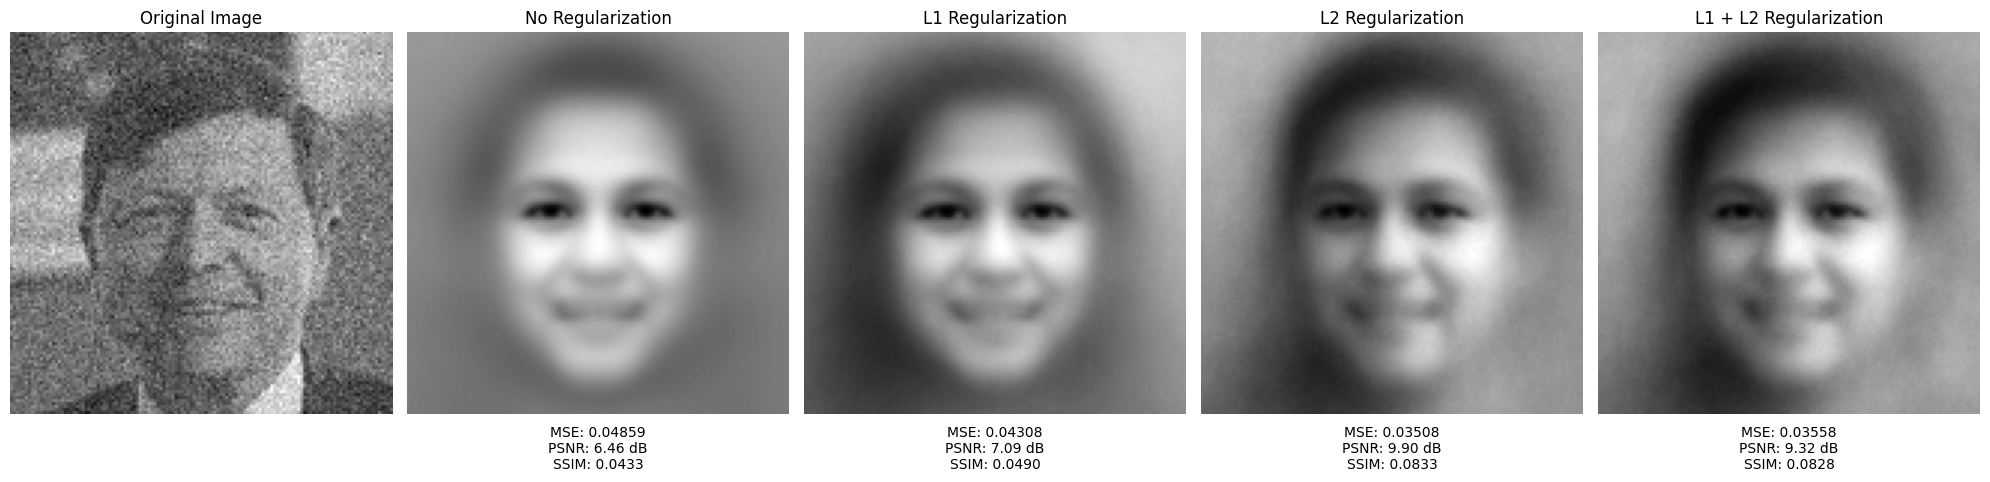

In [19]:

def plot_single_image_reconstructions(image_index, model_paths, titles, test_loader, device, X_DIM, Z_DIM, HIDDEN_SIZE):
    # Get a batch of test images
    images, _ = next(iter(test_loader))  # Get a batch from the test loader
    images = images.to(device)  # Move to device
    
    # Select the image to be reconstructed
    original_img = images[image_index].cpu().numpy()

    # Initialize the plot
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(20, 5))
    
    # Plot the original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    for i, (model_path, title) in enumerate(zip(model_paths, titles), start=1):
        # Load and evaluate the model
        vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
        vae.load_state_dict(torch.load(model_path))
        vae.eval()
        
        # Reconstruct the image
        with torch.no_grad():
            img_tensor = images[image_index].unsqueeze(0).to(device)
            img_flattened = img_tensor.view(img_tensor.size(0), -1)
            vae_samples = vae(img_flattened)
            
            # If vae_samples is a tuple, extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]
            
            vae_samples_reshaped = vae_samples.view(-1, 128, 128).cpu().numpy()[0]
        
        # Convert images and VAE samples to numpy arrays
        original_img_float = original_img[0]  # Remove channel dimension
        vae_sample_img_float = vae_samples_reshaped
        
        # Calculate MSE, SSIM, and PSNR
        mse_value = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
        psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        
        # Plot reconstructed image
        axes[i].imshow(vae_sample_img_float, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
        
        # Add MSE, PSNR, and SSIM text without additional gap
        axes[i].text(0.5, -0.03, 
                     f'MSE: {mse_value:.5f}\nPSNR: {psnr_value:.2f} dB\nSSIM: {ssim_value:.4f}', 
                     ha='center', va='top', transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    plt.tight_layout()
    plt.show()

# Define your model paths and titles
model_paths = [
    "vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth"
]
titles = ["No Regularization", "L1 Regularization", "L2 Regularization" ,"L1 + L2 Regularization"]

# Choose an image index from the test loader
image_index = 0  # Change this index as needed

# Call the function
plot_single_image_reconstructions(
    image_index=image_index,
    model_paths=model_paths,
    titles=titles,
    test_loader=test_loader_noisy,
    device=device,
    X_DIM=X_DIM,
    Z_DIM=Z_DIM,
    HIDDEN_SIZE=HIDDEN_SIZE
)
